In [1]:

import numpy as np
import sys
import os
import time
import matplotlib.pyplot as plt

from antinature.core.molecular_data import MolecularData
from antinature.core.basis import MixedMatterBasis
from antinature.core.integral_engine import AntinatureIntegralEngine
from antinature.core.hamiltonian import AntinatureHamiltonian
from antinature.core.scf import AntinatureSCF
from antinature.core.correlation import AntinatureCorrelation


Qiskit successfully imported.
Primitives (Estimator) available.


In [2]:

def run_h2_molecule():
    """
    Test correlation methods on the simplest molecule - H2.
    
    H2 is the most basic molecular system and serves as a good reference.
    """
    print("\n=== H2 Molecule Analysis ===\n")
    
    # Create H2 molecule (in Bohr units)
    h2_data = MolecularData(
        atoms=[
            ('H', np.array([0.0, 0.0, 0.0])),
            ('H', np.array([0.0, 0.0, 0.74]))
        ],
        n_electrons=2,  # H: 1e each
        n_positrons=0,
        charge=0,
        name="Hydrogen Molecule",
        description="Hydrogen molecule (H2) with bond length 0.74 Bohr"
    )
    
    # Print molecular information
    print(f"Molecule: {h2_data.name}")
    print(f"Description: {h2_data.description}")
    print(f"Formula: {h2_data.get_formula()}")
    print(f"Number of electrons: {h2_data.n_electrons}")
    print(f"Nuclear repulsion energy: {h2_data.get_nuclear_repulsion_energy():.8f} Hartree")
    
    # Create a basis set
    basis = MixedMatterBasis()
    basis.create_for_molecule(
        atoms=h2_data.atoms,
        e_quality='minimal',
        p_quality='minimal'
    )
    
    # Print basis information
    basis_info = basis.electron_basis.get_function_types()
    print("\nBasis set information:")
    print(f"Total basis functions: {len(basis.electron_basis)}")
    print(f"Function types: {basis_info}")
    
    # Create integral engine
    engine = AntinatureIntegralEngine()
    
    # Create Hamiltonian
    print("\nBuilding Hamiltonian...")
    t_start = time.time()
    hamiltonian = AntinatureHamiltonian(
        molecular_data=h2_data,
        basis_set=basis,
        integral_engine=engine,
        include_relativistic=False
    )
    
    # Build the Hamiltonian matrices
    h_matrices = hamiltonian.build_hamiltonian()
    t_hamiltonian = time.time() - t_start
    print(f"Hamiltonian built in {t_hamiltonian:.3f} seconds")
    
    # Create SCF solver
    print("\nStarting SCF calculation...")
    t_start = time.time()
    scf = AntinatureSCF(
        hamiltonian=h_matrices,
        basis_set=basis,
        molecular_data=h2_data,
        max_iterations=50,
        convergence_threshold=1e-6,
        use_diis=True,
        damping_factor=0.5,
        print_level=1
    )
    
    # Run SCF calculation
    scf_results = scf.solve_scf()
    t_scf = time.time() - t_start
    print(f"SCF completed in {t_scf:.3f} seconds")
    
    # Print SCF results
    print(f"\nSCF energy: {scf_results['energy']:.10f} Hartree")
    print(f"Convergence: {scf_results['converged']}")
    print(f"Iterations: {scf_results['iterations']}")
    
    # Convert SCF results arrays from lists to NumPy arrays if necessary
    for key in ['C_electron', 'C_positron', 'E_electron', 'E_positron', 'P_electron', 'P_positron']:
        if key in scf_results and isinstance(scf_results[key], list):
            scf_results[key] = np.array(scf_results[key])
    
    # Run correlation calculations
    print("\nStarting correlation calculations...")
    t_start = time.time()
    
    # Create correlation object
    corr = AntinatureCorrelation(
        scf_result=scf_results,
        hamiltonian=h_matrices,
        basis_set=basis,
        print_level=2
    )
    
    # Calculate MP2 energy
    print("\nCalculating MP2 energy...")
    mp2_energy = corr.mp2_energy()
    
    # Print MP2 results
    print("\nMP2 Results:")
    print(f"  Correlation energy: {mp2_energy:.10f} Hartree")
    print(f"  Total energy: {scf_results['energy'] + mp2_energy:.10f} Hartree")
    
    # Try CCSD
    print("\nCalculating CCSD energy...")
    try:
        ccsd_result = corr.ccsd_energy(
            max_iterations=50,
            convergence_threshold=1e-6
        )
        
        # Print CCSD results
        print("\nCCSD Results:")
        if isinstance(ccsd_result, (int, float, np.number)):
            print(f"  Correlation energy: {ccsd_result:.10f} Hartree")
            print(f"  Total energy: {scf_results['energy'] + ccsd_result:.10f} Hartree")
        else:
            print(f"  Result: {ccsd_result}")
    except Exception as e:
        print(f"\nCCSD calculation error: {e}")
    
    t_corr = time.time() - t_start
    print(f"\nCorrelation calculations completed in {t_corr:.3f} seconds")
    
    # Get performance report
    print("\nPerformance Report:")
    perf_report = corr.get_performance_report()
    if perf_report:
        for key, value in perf_report.items():
            print(f"  {key}: {value}")
    
    # Visualize the molecule if matplotlib is available
    try:
        print("\nVisualizing H2 molecule...")
        h2_data.visualize(show_bonds=True)
        plt.savefig('h2_molecule.png')
        print("Visualization saved as 'h2_molecule.png'")
    except Exception as e:
        print(f"Visualization error: {e}")
    
    return {
        "molecule": h2_data,
        "scf_energy": scf_results['energy'],
        "mp2_energy": mp2_energy,
        "ccsd_energy": ccsd_result if 'ccsd_result' in locals() else None,
        "total_mp2_energy": scf_results['energy'] + mp2_energy,
        "total_ccsd_energy": scf_results['energy'] + ccsd_result if 'ccsd_result' in locals() else None
    }



In [3]:
def run_lih_molecule():
    """
    Test correlation methods on a simple LiH molecule.
    
    LiH is a good test case with more electrons than H2 but still simple.
    """
    print("\n=== LiH Molecule Analysis ===\n")
    
    # Create LiH molecule (in Bohr units)
    lih_data = MolecularData(
        atoms=[
            ('Li', np.array([0.0, 0.0, 0.0])),
            ('H', np.array([0.0, 0.0, 3.0]))  # 3.0 Bohr Li-H distance
        ],
        n_electrons=4,  # Li: 3e, H: 1e
        n_positrons=0,
        charge=0,
        name="Lithium Hydride",
        description="Lithium Hydride (LiH) with bond length 3.0 Bohr"
    )
    
    # Print molecular information
    print(f"Molecule: {lih_data.name}")
    print(f"Description: {lih_data.description}")
    print(f"Formula: {lih_data.get_formula()}")
    print(f"Number of electrons: {lih_data.n_electrons}")
    print(f"Nuclear repulsion energy: {lih_data.get_nuclear_repulsion_energy():.8f} Hartree")
    
    # Create a basis set
    basis = MixedMatterBasis()
    basis.create_for_molecule(
        atoms=lih_data.atoms,
        e_quality='minimal',
        p_quality='minimal'
    )
    
    # Print basis information
    basis_info = basis.electron_basis.get_function_types()
    print("\nBasis set information:")
    print(f"Total basis functions: {len(basis.electron_basis)}")
    print(f"Function types: {basis_info}")
    
    # Create integral engine
    engine = AntinatureIntegralEngine()
    
    # Create Hamiltonian
    print("\nBuilding Hamiltonian...")
    t_start = time.time()
    hamiltonian = AntinatureHamiltonian(
        molecular_data=lih_data,
        basis_set=basis,
        integral_engine=engine,
        include_relativistic=False
    )
    
    # Build the Hamiltonian matrices
    h_matrices = hamiltonian.build_hamiltonian()
    t_hamiltonian = time.time() - t_start
    print(f"Hamiltonian built in {t_hamiltonian:.3f} seconds")
    
    # Create SCF solver
    print("\nStarting SCF calculation...")
    t_start = time.time()
    scf = AntinatureSCF(
        hamiltonian=h_matrices,
        basis_set=basis,
        molecular_data=lih_data,
        max_iterations=100,
        convergence_threshold=1e-6,
        use_diis=True,
        damping_factor=0.5,
        print_level=1
    )
    
    # Run SCF calculation
    scf_results = scf.solve_scf()
    t_scf = time.time() - t_start
    print(f"SCF completed in {t_scf:.3f} seconds")
    
    # Print SCF results
    print(f"\nSCF energy: {scf_results['energy']:.10f} Hartree")
    print(f"Convergence: {scf_results['converged']}")
    print(f"Iterations: {scf_results['iterations']}")
    
    # Convert SCF results arrays from lists to NumPy arrays if necessary
    for key in ['C_electron', 'C_positron', 'E_electron', 'E_positron', 'P_electron', 'P_positron']:
        if key in scf_results and isinstance(scf_results[key], list):
            scf_results[key] = np.array(scf_results[key])
    
    # Run correlation calculations
    print("\nStarting correlation calculations...")
    t_start = time.time()
    
    # Create correlation object
    corr = AntinatureCorrelation(
        scf_result=scf_results,
        hamiltonian=h_matrices,
        basis_set=basis,
        frozen_core=True,
        print_level=2
    )
    
    # Calculate MP2 energy
    print("\nCalculating MP2 energy...")
    mp2_energy = corr.mp2_energy()
    
    # Print MP2 results
    print("\nMP2 Results:")
    print(f"  Correlation energy: {mp2_energy:.10f} Hartree")
    print(f"  Total energy: {scf_results['energy'] + mp2_energy:.10f} Hartree")
    
    # Try CCSD (commented out for simplicity in this demo)
    try:
        print("\nCalculating CCSD energy...")
        ccsd_result = corr.ccsd_energy(
            max_iterations=50,
            convergence_threshold=1e-6
        )
        
        # Print CCSD results
        print("\nCCSD Results:")
        if isinstance(ccsd_result, (int, float, np.number)):
            print(f"  Correlation energy: {ccsd_result:.10f} Hartree")
            print(f"  Total energy: {scf_results['energy'] + ccsd_result:.10f} Hartree")
        else:
            print(f"  Result: {ccsd_result}")
    except Exception as e:
        print(f"\nCCSD calculation error: {e}")
    
    t_corr = time.time() - t_start
    print(f"\nCorrelation calculations completed in {t_corr:.3f} seconds")
    
    # Get performance report
    print("\nPerformance Report:")
    perf_report = corr.get_performance_report()
    if perf_report:
        for key, value in perf_report.items():
            print(f"  {key}: {value}")
    
    # Visualize the molecule
    try:
        print("\nVisualizing LiH molecule...")
        lih_data.visualize(show_bonds=True)
        plt.savefig('lih_molecule.png')
        print("Visualization saved as 'lih_molecule.png'")
    except Exception as e:
        print(f"Visualization error: {e}")
    
    return {
        "molecule": lih_data,
        "scf_energy": scf_results['energy'],
        "mp2_energy": mp2_energy,
        "ccsd_energy": ccsd_result if 'ccsd_result' in locals() else None,
        "total_mp2_energy": scf_results['energy'] + mp2_energy,
        "total_ccsd_energy": scf_results['energy'] + ccsd_result if 'ccsd_result' in locals() else None
    }



===== ANTINATURE COMPLEX MOLECULES TEST =====
This script tests various molecular systems
with correlation methods in the antinature package.

=== H2 Molecule Analysis ===

Molecule: Hydrogen Molecule
Description: Hydrogen molecule (H2) with bond length 0.74 Bohr
Formula: H2
Number of electrons: 2
Nuclear repulsion energy: 1.35135135 Hartree

Basis set information:
Total basis functions: 2
Function types: {'s': 2}

Building Hamiltonian...
Hamiltonian built in 0.002 seconds

Starting SCF calculation...
Iteration 1: Energy = -0.6049360645, ΔE = 0.6049360645, Error = 0.0000000000
Iteration 2: Energy = -0.6049360645, ΔE = 0.0000000000, Error = 0.0000000000
SCF converged in 2 iterations!
SCF converged in 2 iterations
Final energy: -0.6049360645 Hartree
Calculation time: 0.00 seconds
SCF completed in 0.003 seconds

SCF energy: -0.6049360645 Hartree
Convergence: True
Iterations: 2

Starting correlation calculations...

Calculating MP2 energy...
Electron-electron MP2 energy: -0.0061420467 Hart

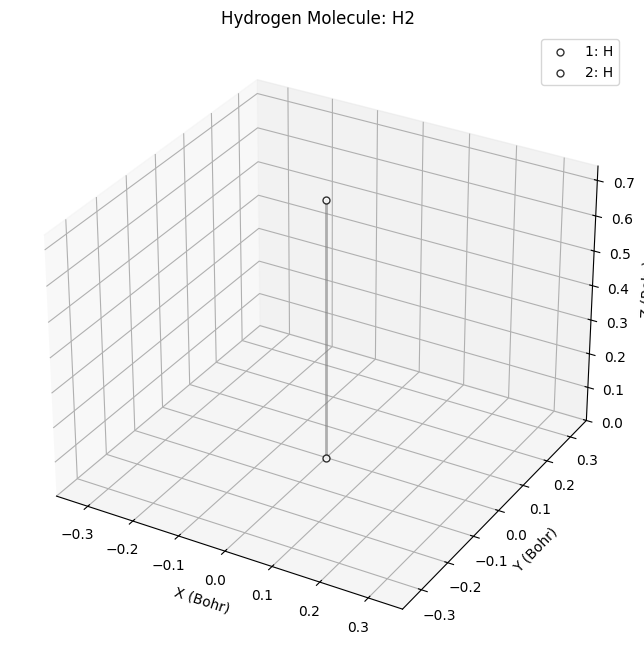

Visualization saved as 'h2_molecule.png'



=== LiH Molecule Analysis ===

Molecule: Lithium Hydride
Description: Lithium Hydride (LiH) with bond length 3.0 Bohr
Formula: HLi
Number of electrons: 4
Nuclear repulsion energy: 1.00000000 Hartree

Basis set information:
Total basis functions: 2
Function types: {'s': 2}

Building Hamiltonian...
Hamiltonian built in 0.001 seconds

Starting SCF calculation...
Iteration 1: Energy = -3.6907240268, ΔE = 3.6907240268, Error = 0.0000000000
Iteration 2: Energy = -3.6907240268, ΔE = 0.0000000000, Error = 0.0000000000
SCF converged in 2 iterations!
SCF converged in 2 iterations
Final energy: -3.6907240268 Hartree
Calculation time: 0.00 seconds
SCF completed in 0.002 seconds

SCF energy: -3.6907240268 Hartree
Convergence: True
Iterations: 2

Starting correlation calculations...

Calculating MP2 energy...

MP2 Results:
  Correlation energy: 0.0000000000 Hartree
  Total energy: -3.6907240268 Hartree

Calculating CCSD energy...

CCSD Results:
  Correlati

<Figure size 640x480 with 0 Axes>

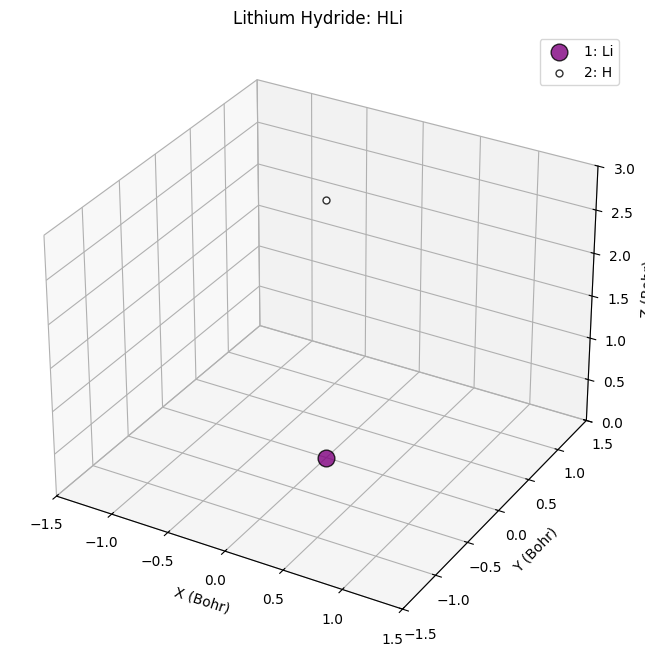

Visualization saved as 'lih_molecule.png'



=== Hybrid Positronic System ===

System: Positronic LiH
Description: Lithium Hydride (LiH) with an additional positron
Formula: HLi(e+1) + e⁺
Number of electrons: 4
Number of positrons: 1
Nuclear repulsion energy: 1.00000000 Hartree

Basis set information:
Electron basis functions: 2
Electron function types: {'s': 2}
Positron basis functions: 4
Positron function types: {'s': 4}

Building Hamiltonian...
Hamiltonian built in 0.004 seconds

Starting SCF calculation...
Iteration 1: Energy = -3.6907240268, ΔE = 3.6907240268, Error = 0.0000000000
Iteration 2: Energy = -3.6907240268, ΔE = 0.0000000000, Error = 0.0000000000
SCF converged in 2 iterations!
SCF converged in 2 iterations
Final energy: -3.6907240268 Hartree
Calculation time: 0.00 seconds
SCF completed in 0.002 seconds

SCF energy: -3.6907240268 Hartree
Convergence: True
Iterations: 2

Starting correlation calculations...

Calculating MP2 energy with electron-positron correlation...

MP2

/workspace/.pyenv_mirror/user/current/lib/python3.12/site-packages/antinature/core/basis.py:681: UserWarning: No positron basis parameters for Li with quality standard
  warnings.warn(


<Figure size 640x480 with 0 Axes>

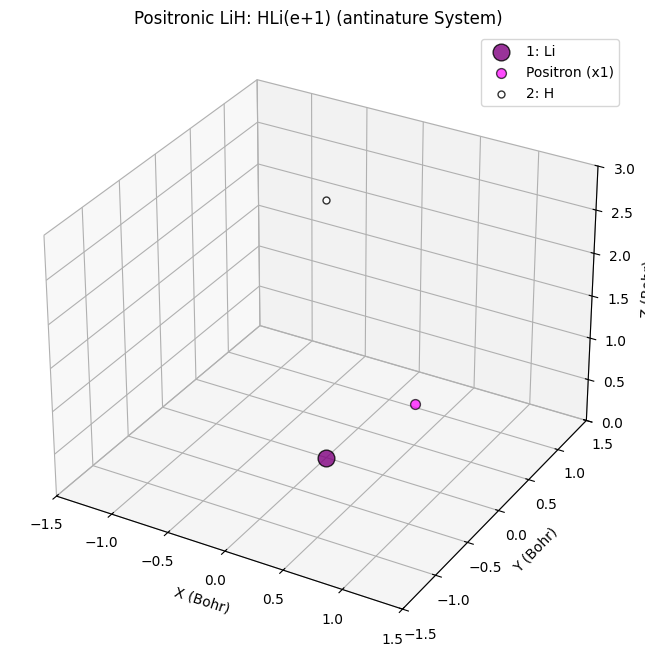

Visualization saved as 'positronic_lih.png'



===== SUMMARY OF RESULTS =====

System: h2
  SCF Energy: -0.6049360645 Hartree
  MP2 Correlation Energy: -0.0061420467 Hartree
  Total MP2 Energy: -0.6110781113 Hartree
  CCSD Correlation Energy: -0.0067562514 Hartree
  Total CCSD Energy: -0.6116923159 Hartree

System: lih
  SCF Energy: -3.6907240268 Hartree
  MP2 Correlation Energy: 0.0000000000 Hartree
  Total MP2 Energy: -3.6907240268 Hartree
  CCSD Correlation Energy: 0.0000000000 Hartree
  Total CCSD Energy: -3.6907240268 Hartree

System: hybrid
  SCF Energy: -3.6907240268 Hartree
  MP2 Correlation Energy: 0.0000000000 Hartree
  Total MP2 Energy: -3.6907240268 Hartree
  Positron Annihilation Rate: 0.000000e+00 s^-1

Tests completed!


<Figure size 640x480 with 0 Axes>

In [ ]:
def run_hybrid_positronic_molecule():
    """
    Test a hybrid molecule with both electrons and positrons.
    
    This example creates a simpler system with a positron for better convergence.
    """
    print("\n=== Hybrid Positronic System ===\n")
    
    # Create a simple LiH molecule with a positron
    hybrid_data = MolecularData(
        atoms=[
            ('Li', np.array([0.0, 0.0, 0.0])),
            ('H', np.array([0.0, 0.0, 3.0]))  # 3.0 Bohr Li-H distance
        ],
        n_electrons=4,   # Li: 3e, H: 1e
        n_positrons=1,   # One positron
        charge=0,
        name="Positronic LiH",
        description="Lithium Hydride (LiH) with an additional positron"
    )
    
    # Print molecular information
    print(f"System: {hybrid_data.name}")
    print(f"Description: {hybrid_data.description}")
    print(f"Formula: {hybrid_data.get_formula()} + e⁺")
    print(f"Number of electrons: {hybrid_data.n_electrons}")
    print(f"Number of positrons: {hybrid_data.n_positrons}")
    print(f"Nuclear repulsion energy: {hybrid_data.get_nuclear_repulsion_energy():.8f} Hartree")
    
    # Create a basis set with good quality for both electrons and positrons
    basis = MixedMatterBasis()
    basis.create_for_molecule(
        atoms=hybrid_data.atoms,
        e_quality='minimal',    # Use minimal for electrons for efficiency
        p_quality='standard'    # Better quality for positron (few positrons = less computational cost)
    )
    
    # Print basis information
    e_basis_info = basis.electron_basis.get_function_types()
    p_basis_info = basis.positron_basis.get_function_types() if basis.positron_basis else {}
    
    print("\nBasis set information:")
    print(f"Electron basis functions: {len(basis.electron_basis)}")
    print(f"Electron function types: {e_basis_info}")
    print(f"Positron basis functions: {len(basis.positron_basis) if basis.positron_basis else 0}")
    print(f"Positron function types: {p_basis_info}")
    
    # Create integral engine
    engine = AntinatureIntegralEngine()
    
    # Create Hamiltonian with annihilation (electron-positron interaction)
    print("\nBuilding Hamiltonian...")
    t_start = time.time()
    hamiltonian = AntinatureHamiltonian(
        molecular_data=hybrid_data,
        basis_set=basis,
        integral_engine=engine,
        include_relativistic=True,
        include_annihilation=True
    )
    
    # Build the Hamiltonian matrices
    h_matrices = hamiltonian.build_hamiltonian()
    t_hamiltonian = time.time() - t_start
    print(f"Hamiltonian built in {t_hamiltonian:.3f} seconds")
    
    # Create SCF solver
    print("\nStarting SCF calculation...")
    t_start = time.time()
    scf = AntinatureSCF(
        hamiltonian=h_matrices,
        basis_set=basis,
        molecular_data=hybrid_data,
        max_iterations=100,
        convergence_threshold=1e-6,
        use_diis=True,
        damping_factor=0.5,
        print_level=1
    )
    
    # Run SCF calculation
    scf_results = scf.solve_scf()
    t_scf = time.time() - t_start
    print(f"SCF completed in {t_scf:.3f} seconds")
    
    # Print SCF results
    print(f"\nSCF energy: {scf_results['energy']:.10f} Hartree")
    print(f"Convergence: {scf_results['converged']}")
    print(f"Iterations: {scf_results['iterations']}")
    
    # Convert SCF results arrays from lists to NumPy arrays if necessary
    for key in ['C_electron', 'C_positron', 'E_electron', 'E_positron', 'P_electron', 'P_positron']:
        if key in scf_results and isinstance(scf_results[key], list):
            scf_results[key] = np.array(scf_results[key])
    
    # Run correlation calculations
    print("\nStarting correlation calculations...")
    t_start = time.time()
    
    # Create correlation object
    corr = AntinatureCorrelation(
        scf_result=scf_results,
        hamiltonian=h_matrices,
        basis_set=basis,
        frozen_core=True,
        print_level=2
    )
    
    # Calculate MP2 energy with electron-positron correlation
    print("\nCalculating MP2 energy with electron-positron correlation...")
    mp2_energy = corr.mp2_energy(include_electron_positron=True)
    
    # Print MP2 results
    print("\nMP2 Results:")
    print(f"  Correlation energy: {mp2_energy:.10f} Hartree")
    print(f"  Total energy: {scf_results['energy'] + mp2_energy:.10f} Hartree")
    
    # Calculate annihilation rate
    try:
        print("\nCalculating positron annihilation rate...")
        annihilation_rate = corr.calculate_annihilation_rate()
        print(f"Positron annihilation rate: {annihilation_rate:.6e} s^-1")
    except Exception as e:
        print(f"\nAnnihilation rate calculation error: {e}")
    
    # Calculate CCSD energy for positronium
    try:
        ps_ccsd_result = corr.ccsd_energy(
            max_iterations=50,
            convergence_threshold=1e-6,
            include_electron_positron=True
        )
        
        # Print CCSD results
        print("\nCCSD Results for Positronium:")
        if isinstance(ps_ccsd_result, (int, float, np.number)):
            print(f"  Correlation energy: {ps_ccsd_result:.10f} Hartree")
            print(f"  Total energy: {scf_results['energy'] + ps_ccsd_result:.10f} Hartree")
        else:
            print(f"  Result: {ps_ccsd_result}")
    except Exception as e:
        print(f"\nPositronium CCSD calculation error: {e}")
    
    t_corr = time.time() - t_start
    print(f"\nCorrelation calculations completed in {t_corr:.3f} seconds")
    
    # Visualize the molecule
    try:
        print("\nVisualizing hybrid system...")
        hybrid_data.visualize(show_bonds=True)
        plt.savefig('positronic_lih.png')
        print("Visualization saved as 'positronic_lih.png'")
    except Exception as e:
        print(f"Visualization error: {e}")
    
    return {
        "molecule": hybrid_data,
        "scf_energy": scf_results['energy'],
        "mp2_energy": mp2_energy,
        "total_mp2_energy": scf_results['energy'] + mp2_energy,
        "annihilation_rate": annihilation_rate if 'annihilation_rate' in locals() else None
    }


if __name__ == "__main__":
    print("===== ANTINATURE COMPLEX MOLECULES TEST =====")
    print("This script tests various molecular systems")
    print("with correlation methods in the antinature package.")
    
    # Create examples directory if it doesn't exist
    os.makedirs("examples/results", exist_ok=True)
    
    # Run all examples and collect results
    results = {}
    
    try:
        results["h2"] = run_h2_molecule()
        print("\n" + "="*60 + "\n")
    except Exception as e:
        print(f"Error in H2 example: {e}")
    
    try:
        results["lih"] = run_lih_molecule()
        print("\n" + "="*60 + "\n")
    except Exception as e:
        print(f"Error in LiH example: {e}")
    
    try:
        results["hybrid"] = run_hybrid_positronic_molecule()
        print("\n" + "="*60 + "\n")
    except Exception as e:
        print(f"Error in hybrid positronic molecule example: {e}")
    
    # Generate a summary report
    print("\n===== SUMMARY OF RESULTS =====\n")
    
    for system_name, system_results in results.items():
        print(f"System: {system_name}")
        if "scf_energy" in system_results:
            print(f"  SCF Energy: {system_results['scf_energy']:.10f} Hartree")
        if "mp2_energy" in system_results:
            print(f"  MP2 Correlation Energy: {system_results['mp2_energy']:.10f} Hartree")
        if "total_mp2_energy" in system_results:
            print(f"  Total MP2 Energy: {system_results['total_mp2_energy']:.10f} Hartree")
        if "ccsd_energy" in system_results and system_results["ccsd_energy"] is not None:
            print(f"  CCSD Correlation Energy: {system_results['ccsd_energy']:.10f} Hartree")
        if "total_ccsd_energy" in system_results and system_results["total_ccsd_energy"] is not None:
            print(f"  Total CCSD Energy: {system_results['total_ccsd_energy']:.10f} Hartree")
        if "annihilation_rate" in system_results and system_results["annihilation_rate"] is not None:
            print(f"  Positron Annihilation Rate: {system_results['annihilation_rate']:.6e} s^-1")
        print()
    
    print("Example completed!") 